<a href="https://colab.research.google.com/github/dvschultz/ml-art-colabs/blob/master/ML4A_TSNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is modified from the [ML4A](https://github.com/ml4a/ml4a/blob/master/examples/info_retrieval/image-tsne.ipynb) repo to work with a custom dataset.

Make sure you set `Runtime` > `Change runtime type` > `Hardware Accelerator` to GPU.

# Image t-SNE

This notebook will take you through the process of generating a [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) of a set of images, using a feature vector for each image derived from the activations of the last fully-connected layer in a pre-trained convolutional neural network (convnet).

## Feature extraction and reverse image search
This notebook will guide you through the procedure of analyzing a large set of images using a pre-trained convolutional network, extracting feature vectors for each one which represent each image.

After the analysis is done, we will review some retrieval tasks that you can do with such an analysis. The main task will be that of "reverse image search," which refers to searching for the most similar set of images to some query image.

### Prepare a dataset
You will need a folder of images to analyze. There is no limit to the size of the dataset, but for good results, at least 1000 would be good.

I have uploaded a dataset to my Google Drive and will access it by conncting Drive to Colab. Run the cell below and walk thru the steps to connect your Drive account.



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Next I’ll copy my zip file out of Drive and into Colab. Then I’ll unzip it.

In [6]:
!cp /content/drive/MyDrive/recycling_center.zip /content/recycling_center.zip
!unzip /content/recycling_center.zip

Archive:  /content/recycling_center.zip
   creating: recycling_center/
  inflating: recycling_center/515517373.jpg  
  inflating: recycling_center/2465341649.jpg  
  inflating: recycling_center/2149123488.jpg  
  inflating: recycling_center/2575684938.jpg  
  inflating: recycling_center/900729485.jpg  
  inflating: recycling_center/2466154784.jpg  
  inflating: recycling_center/1239971779.jpg  
  inflating: recycling_center/2117750009.jpg  
  inflating: recycling_center/2329718647.jpg  
  inflating: recycling_center/2611837090.jpg  
  inflating: recycling_center/1803024490.jpg  
  inflating: recycling_center/2473242471.jpg  
  inflating: recycling_center/235109505.jpg  
  inflating: recycling_center/1926395380.jpg  
  inflating: recycling_center/1802180027.jpg  
  inflating: recycling_center/538576129.jpg  
  inflating: recycling_center/2227125698.jpg  
  inflating: recycling_center/2763754414.jpg  
  inflating: recycling_center/2587934961.jpg  
  inflating: recycling_center/901593920.

Next we’ll load some libraries and packages needed

In [7]:
%matplotlib inline
import os
import random
import numpy as np
import json
import matplotlib.pyplot as plt
import pickle
from matplotlib.pyplot import imshow
from PIL import Image
from sklearn.manifold import TSNE

import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model

OK now we’re mostly set up. We can start analyzing our features. Let’s load a pretrained model called VGG16 to analyze our images.

In [8]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)

Let's look at the model summary to see how it's structured.

In [9]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Forwarding an image through the network
In order to input an image into the network, it has to be pre-processed into a feature vector of the correct size. To help us do this, we will create a function load_image(path) which will handle the usual pre-processing steps: load an image from our file system and turn it into an input vector of the correct dimensions, those expected by VGG16, namely a color image of size 224x224.

In [10]:
def load_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

We'll load an image in from our dataset, and take a look at its data vector.

shape of x:  (1, 224, 224, 3)
data type:  float32


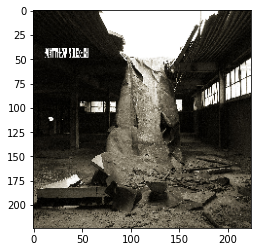

In [14]:
img, x = load_image("/content/recycling_center/10715801114.jpg")
print("shape of x: ", x.shape)
print("data type: ", x.dtype)
plt.imshow(img)

The shape of the image is [1, 224, 224, 3]. The reason it has the extra first dimension with 1 element is that the network can take batches of images to process them all simultaneously. So for example, 10 images can be propagated through the network if x has a shape of [10, 224, 224, 3].

Let's get class predictions from this model. We forward x through model and then use the built-in decode_predictions to look up the class names.

In [15]:
# forward the image through the network
predictions = model.predict(x)

# print out the 
for _, pred, prob in decode_predictions(predictions)[0]:
    print("predicted %s with probability %0.3f" % (pred, prob))

40960/35363 [==================================] - 0s 0us/step
predicted thatch with probability 0.299
predicted lumbermill with probability 0.202
predicted chain_saw with probability 0.078
predicted cliff_dwelling with probability 0.035
predicted megalith with probability 0.019


### Feature extraction
What we have in the model variable is a highly effective image classifier trained on the ImageNet database. We expect that the classifier must form a very effective representation of the image in order to be able to classify it with such high accuracy. We can use this to our advantage by re-purposing this for another task.

What we do is we copy the model, but remove the last layer (the classification layer), so that the final layer of the new network, called feat_extractor is the second 4096-neuron fully-connected layer, "fc2 (Dense)".

The way we do this is by instantiating a new model called feature_extractor which takes a reference to the desired input and output layers in our VGG16 model. Thus, feature_extractor's output is the layer just before the classification, the last 4096-neuron fully connected layer. It looks like a copy, but internally, all Keras is doing is making a pointer to each of these layers and not actually copying anything. Thus, the output "prediction" from feat_extractor will just be the layer fc2 from model.

If we run the summary() function again, we see that the architecture of feat_extractor is identical to the original model, except the last layer has been removed. We also know that not just the architecture is the same, but the two have the same weights as well.

In [16]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Now let's see the feature extractor in action. We pass the same image from before into it, and look at the results. The predict function returns an array with one element per image (in our case, there is just one). Each element contains a 4096-element array, which is the activations of the last fully-connected layer fc2 in VGG16. Let's plot the array as well.

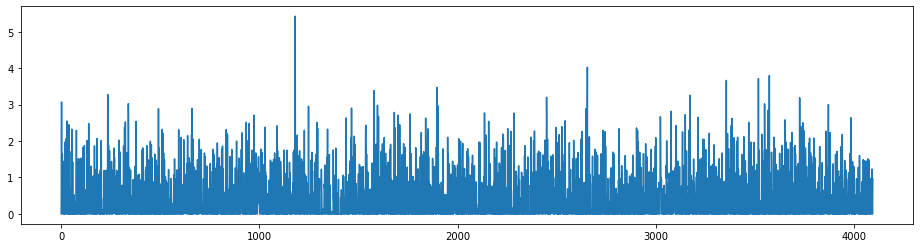

In [17]:
img, x = load_image("/content/recycling_center/101373297.jpg")
feat = feat_extractor.predict(x)

plt.figure(figsize=(16,4))
plt.plot(feat[0])

Our expectation is that the fc2 activations form a very good representation of the image, such that similar images should produce similar activations. In other words, the fc2 activations of two images which have similar content should be very close to each other. We can exploit this to do information retrieval.

In the next cell, we will open a folder of images for analysis. First, the next cell will just recursively crawl the folder specified by image_path looking for images of the extensions inside of image_extensions and then limiting them to a random subset of maximum max_num_images images. Change these variables if you wish to change the target images.

In [27]:
!rm /content/recycling_center/2111608980.jpg
!rm /content/recycling_center/2086548971.jpg

rm: cannot remove '/content/recycling_center/2086548971.jpg': No such file or directory


In [28]:
images_path = '/content/recycling_center'
image_extensions = ['.jpg', '.png', '.jpeg']   # case-insensitive (upper/lower doesn't matter)
max_num_images = 10000

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(xrange(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))

keeping 1930 images to analyze


In the next cell, we will begin a loop which will open each image, extract its feature vector, and append it to a list called features which will contain our activations for each image. This process may take a long time depending on your graphics card, so you may need to leave it running for as much as a few hours. On a good graphics card, this process may only take a half hour or so. Every 1000 images, you will receive a notification print-out.

In [29]:
import time
tic = time.perf_counter()

features = []
for i, image_path in enumerate(images):
    if i % 500 == 0:
        toc = time.clock()
        elap = toc-tic;
        print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(images),elap))
        tic = time.clock()
    print(image_path)
    img, x = load_image(image_path);
    feat = feat_extractor.predict(x)[0]
    features.append(feat)

print('finished extracting features for %d images' % len(images))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.


analyzing image 0 / 1930. Time: -3276.8641 seconds.
/content/recycling_center/2465325947.jpg
/content/recycling_center/900729909.jpg
/content/recycling_center/10716000773.jpg
/content/recycling_center/1398340202.jpg
/content/recycling_center/250527850.jpg
/content/recycling_center/514303130.jpg
/content/recycling_center/2466148340.jpg
/content/recycling_center/2465324059.jpg
/content/recycling_center/495768133.jpg
/content/recycling_center/2452775030.jpg
/content/recycling_center/2466151860.jpg
/content/recycling_center/1555061856.jpg
/content/recycling_center/25405598257.jpg
/content/recycling_center/1803030208.jpg
/content/recycling_center/2335209679.jpg
/content/recycling_center/901582704.jpg
/content/recycling_center/10660684046.jpg
/content/recycling_center/176686512.jpg
/content/recycling_center/354932596.jpg
/content/recycling_center/2216538055.jpg
/content/recycling_center/900728169.jpg
/content/recycling_center/2291784428.jpg
/content/recycling_center/2276016989.jpg
/content/r

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (100387791 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


/content/recycling_center/404604011.jpg
/content/recycling_center/86130598.jpg
/content/recycling_center/3976525467.jpg
/content/recycling_center/2466165036.jpg
/content/recycling_center/256227689.jpg
/content/recycling_center/1024403878.jpg
/content/recycling_center/2360098666.jpg
/content/recycling_center/1803003488.jpg
/content/recycling_center/23994741.jpg
/content/recycling_center/1802180381.jpg
/content/recycling_center/2213789884.jpg
/content/recycling_center/872621389.jpg
/content/recycling_center/2466153196.jpg
/content/recycling_center/19596690.jpg
/content/recycling_center/665223620.jpg
/content/recycling_center/259293130.jpg
/content/recycling_center/2219137207.jpg
/content/recycling_center/2456176685.jpg
/content/recycling_center/2217330272.jpg
/content/recycling_center/1747553102.jpg
/content/recycling_center/2525193614.jpg
/content/recycling_center/2148392823.jpg
/content/recycling_center/235109582.jpg
/content/recycling_center/2212100073.jpg
/content/recycling_center/20

Alone, these activations provide a good representation, but it is a good idea to do one more step before using these as our feature vectors, which is to do a principal component analysis (PCA) to reduce the dimensionality of our feature vectors down to 300. We apply PCA for two reasons: 1) the 4096-bit feature vector may have some redundancy in it, such that multiple elements in the vector are highly correlated or similar. This would skew similarity comparisons towards those over-represented features. 2) Operating over 4096 elements is inefficient both in terms of space/memory requirements and processor speed, and it would be better for us if we can reduce the length of these vectors but maintain the same effective representation. PCA allows us to do this by reducing the dimensionality down of the feature vectors from 4096 to much less, but maintain a representation which is still faithful to the original data, by preserving the relative inter-point distance.

Thus, PCA reduces the amount of redundancy in our features (from duplicate or highly-correlated features), speeds up computation over them, and reduces the amount of memory they take up.

The next cell will instantiate a PCA object, which we will then fit our data to, choosing to keep the top 300 principal components. This may take a few minutes.

In [30]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)

PCA(copy=True, iterated_power='auto', n_components=300, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

The pca object stores the actual transformation matrix which was fit in the previous cell. We can now use it to transform any original feature vector (of length 4096) into a reduced 300-dimensional feature vector in the principal component space found by the PCA.

So we take our original feature vectors, and transform them to the new space.

In [31]:
pca_features = pca.transform(features)

We need to save both the image features matrix (the PCA-reduced features, not the originals), as well as the array containing the paths to each image, to make sure we can line up the images to their corresponding vectors. It is also best to save pca itself so we can project new images into the space if we wish. We can save everything to disk using pickle.

In [32]:
import pickle

pickle.dump([images, pca_features, pca], open('/content/features.pkl', 'wb'))

## TSNE

First, we will load our image paths and feature vectors from the previous notebook step into memory. We can print their contents to get an idea of what they look like.

In [33]:
images, pca_features, pca = pickle.load(open('/content/features.pkl', 'rb'))

for img, f in list(zip(images, pca_features))[0:5]:
    print("image: %s, features: %0.2f,%0.2f,%0.2f,%0.2f... "%(img, f[0], f[1], f[2], f[3]))

image: /content/recycling_center/2465325947.jpg, features: 10.51,-8.16,15.90,19.87... 
image: /content/recycling_center/900729909.jpg, features: -8.01,-16.97,7.96,1.67... 
image: /content/recycling_center/10716000773.jpg, features: 4.37,16.69,-2.67,4.90... 
image: /content/recycling_center/1398340202.jpg, features: -0.84,-17.06,6.80,2.48... 
image: /content/recycling_center/250527850.jpg, features: -5.59,0.14,-1.34,20.51... 


Although in principle t-SNE works with any number of images, it's difficult to place that many tiles in a single image. So instead, we will take a random subset of 1000 images and plot those on a t-SNE instead. This step is optional, or you can try changing `num_images_to_plot`.

In [34]:
num_images_to_plot = 1000

if len(images) > num_images_to_plot:
    sort_order = sorted(random.sample(range(len(images)), num_images_to_plot))
    images = [images[i] for i in sort_order]
    pca_features = [pca_features[i] for i in sort_order]

It is usually a good idea to first run the vectors through a faster dimensionality reduction technique like [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) to project your data into an intermediate lower-dimensional space before using t-SNE. This improves accuracy, and cuts down on runtime since PCA is more efficient than t-SNE. Since we have already projected our data down with PCA in the previous notebook, we can proceed straight to running the t-SNE on the feature vectors. Run the command in the following cell, taking note of the arguments:

- `n_components` is the number of dimensions to project down to. In principle it can be anything, but in practice t-SNE is almost always used to project to 2 or 3 dimensions for visualization purposes.
- `learning_rate` is the step size for iterations. You usually won't need to adjust this much, but your results may vary slightly. 
- `perplexity` refers to the number of independent clusters or zones t-SNE will attempt to fit points around. Again, it is relatively robust to large changes, and usually 20-50 works best. 
- `angle` controls the speed vs accuracy tradeoff. Lower angle means better accuracy but slower, although in practice, there is usually little improvement below a certain threshold.

In [35]:
X = np.array(pca_features)
tsne = TSNE(n_components=2, learning_rate=150, perplexity=30, angle=0.2, verbose=2).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.034s...
[t-SNE] Computed neighbors for 1000 samples in 0.641s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 18.525341
[t-SNE] Computed conditional probabilities in 0.103s
[t-SNE] Iteration 50: error = 78.1771393, gradient norm = 0.3017317 (50 iterations in 1.122s)
[t-SNE] Iteration 100: error = 78.4077759, gradient norm = 0.3082206 (50 iterations in 1.119s)
[t-SNE] Iteration 150: error = 80.7604218, gradient norm = 0.2563422 (50 iterations in 1.024s)
[t-SNE] Iteration 200: error = 79.8233185, gradient norm = 0.2639932 (50 iterations in 1.015s)
[t-SNE] Iteration 250: error = 79.7683716, gradient norm = 0.2892246 (50 iterations in 1.028s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.768372
[t-SNE] Iteration 300: error = 1.9609652, gradient norm = 0.0028767 (50 iterations in 0.849s)
[t-SNE] Iteration 350: error = 1.7855418, gradient norm = 0.0009

Internally, t-SNE uses an iterative approach, making small (or sometimes large) adjustments to the points. By default, t-SNE will go a maximum of 1000 iterations, but in practice, it often terminates early because it has found a locally optimal (good enough) embedding.

The variable `tsne` contains an array of unnormalized 2d points, corresponding to the embedding. In the next cell, we normalize the embedding so that lies entirely in the range (0,1).

In [36]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

Finally, we will compose a new RGB image where the set of images have been drawn according to the t-SNE results. Adjust `width` and `height` to set the size in pixels of the full image, and set `max_dim` to the pixel size (on the largest size) to scale images to.

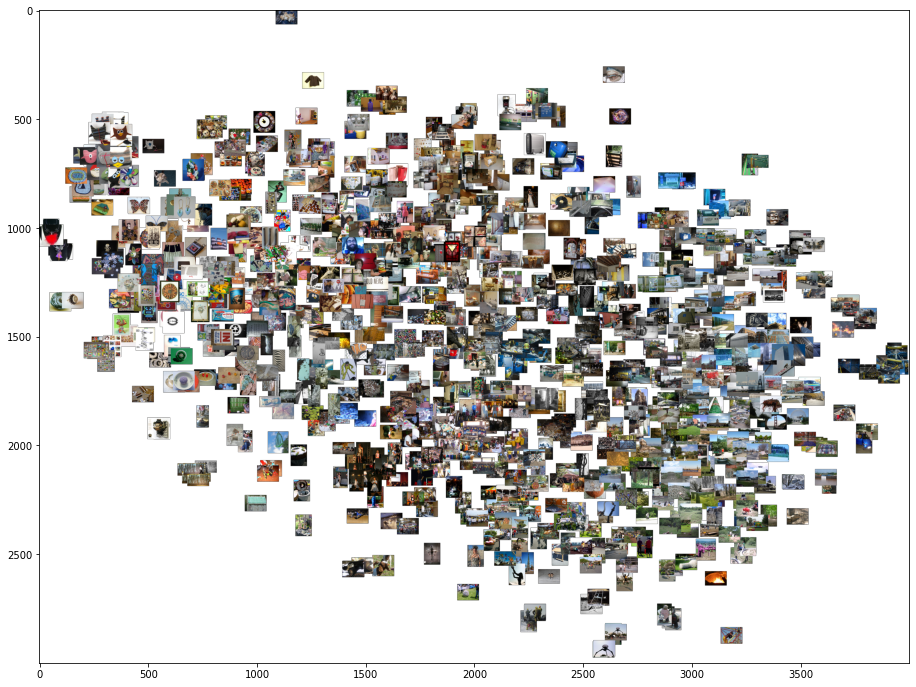

In [37]:
width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(images, tx, ty):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)

You can save the image to disk:

In [38]:
full_image.save("/content/recycling_center-tsne.png")

Now that we have generated our t-SNE, one more nice thing we can optionally do is to take the 2d embedding and assign it to a grid, using [RasterFairy](https://github.com/Quasimondo/RasterFairy). We can optionally choose a grid size of rows (`nx`) and columns (`ny`), which should be equal to the number of images you have. If it is less, then you can simply cut the `tsne` and `images` lists to be equal to `nx * ny`.

If you omit the `target=(nx, ny)` argument, RasterFairy will automatically choose an optimal grid size to be as square-shaped as possible. RasterFairy also has options for embedding them in a grid with irregular borders as well (see the GitHub page for more details).

You can also save the t-SNE points and their associated image paths for further processing in another environment.

In [39]:
tsne_path = "/content/example-tSNE-points.json"

data = [{"path":os.path.abspath(img), "point":[float(x), float(y)]} for img, x, y in zip(images, tx, ty)]
with open(tsne_path, 'w') as outfile:
    json.dump(data, outfile)

print("saved t-SNE result to %s" % tsne_path)

saved t-SNE result to /content/example-tSNE-points.json


If you'd like to follow the last section which converts the t-SNE points to a grid assignment, you'll need [bmcfee's fork of Mario Klingemann's RasterFairy](https://github.com/bmcfee/RasterFairy), which can be installed with `pip` in with the following command.

In [ ]:
pip install -U git+https://github.com/bmcfee/RasterFairy/

In [49]:
import rasterfairy

# nx * ny = 1000, the number of images
nx = 40
ny = 25

# assign to grid
grid_assignment = rasterfairy.transformPointCloud2D(tsne, target=(nx, ny))

Now finally, we can make a new image of our grid. Set the `tile_width` and `tile_height` variables according to how big you want the individual tile images to be. The resolution of the output image is `tile_width * nx` x `tile_height * ny`. The script will automatically center-crop all the tiles to match the aspect ratio of `tile_width / tile_height`.

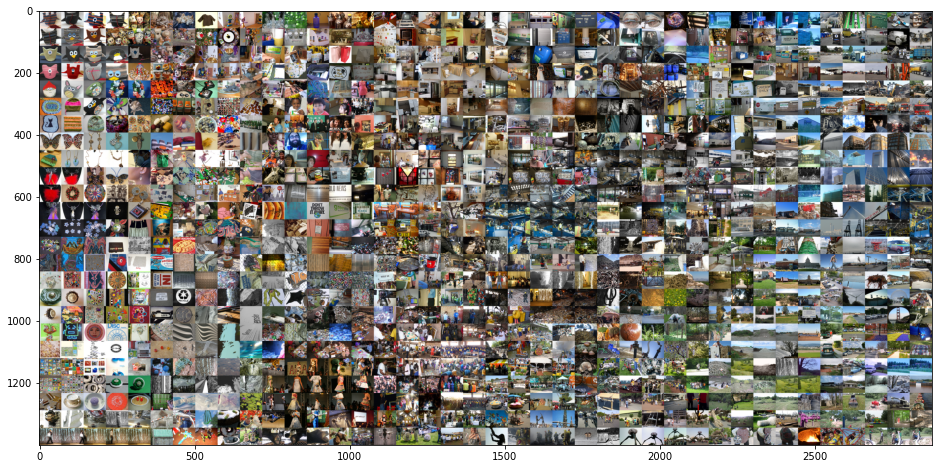

In [50]:
tile_width = 72
tile_height = 56

full_width = tile_width * nx
full_height = tile_height * ny
aspect_ratio = float(tile_width) / tile_height

grid_image = Image.new('RGB', (full_width, full_height))

for img, grid_pos in zip(images, grid_assignment[0]):
    idx_x, idx_y = grid_pos
    x, y = tile_width * idx_x, tile_height * idx_y
    tile = Image.open(img)
    tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
    if (tile_ar > aspect_ratio):
        margin = 0.5 * (tile.width - aspect_ratio * tile.height)
        tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
    else:
        margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
        tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
    tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
    grid_image.paste(tile, (int(x), int(y)))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(grid_image)

Finally, we can save the gridded t-SNE to disk as well.

In [51]:
grid_image.save("/content/recycling_center-tsne-2dgrid.jpg")